In this homework we will analyze the spread of Influenza H1N1 in Sweden in 2009. To perform this task we will use randrom graphs and the SIR model.

As nodes we consider the swedish population. For sake of convenience, we will use a low number of nodes (500) for the first simulations and then the swedish population rescaled by a factor of $10^4$ (934) for the last ones. We will call each individual **agent**, each of them is associated with a state related to the H1N1-virus infection. The possible states are the following:
* susceptible (S): the agent could get the virus.
* infected (I): the agent has the virus and it can infect other agents directly connected to it with an edge.
* recovered (R): the agent was affected by the virus but it has recovered.
* vaccinated (V): the agent is vaccinated and it is immune from the virus.

Notice that we will use the SIR model, which is not taking into consideration others aspects of the infection as the incubation period, the immunity period, the death rate.

# 1 Preliminary parts

## 1.1 Epidemic on a known graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

In [2]:
# function for the SIR model

# Inputs:
# G:                    the graoh used for the simulation
# N:                    the number of nodes or agents
# beta:                 infection rate
# rho:                  recovery rate
# n_weeks:              the number of weeks 
# I0:                   infected agents at week o
# V:                    vector with the vaccination percentages (optional)

# Outputs:
# susceptibles                vector containing the number of susceptible agents 
#                              for each week
# infected, new_infected      vectors containing the number of infected 
#                               and new infected agents for each week
# recovered                   vector containing the number of recovered agents 
#                               for each week
# vaccinated, new_vaccinated  vectors containing the number of vaccinated 
#                                and new vaccinated agents for each week

def SIR_simulation(G, N, beta, rho, n_weeks, I0, V=[]):
  # possible states
  # S = 0
  # I = 1
  # R = 2
  # V = 3

  agents = np.zeros(N, dtype="int")
  appo_agents = np.zeros(N, dtype="int")

  # define the initial infected agents
  seed = [np.random.choice(N-1, size = I0)]
  for s in seed:
    agents[s] = 1

  # define states vectors
  susceptibles = np.zeros(n_weeks, dtype="int")
  infected = np.zeros(n_weeks, dtype="int")
  recovered = np.zeros(n_weeks, dtype="int")
  new_infected = np.zeros(n_weeks, dtype="int")
  vaccinated = np.zeros(n_weeks, dtype="int")
  new_vaccinated = np.zeros(n_weeks, dtype="int")

  # define initial conditions
  susceptibles[0] = N - I0
  infected[0] = I0
  susceptibles[0] = len(np.where(agents[:] == 0)[0])
  infected[0] = len(np.where(agents[:] == 1)[0])
  recovered[0] = len(np.where(agents[:] == 2)[0])
  already_vaccinated_agents = 0

  # for every week
  for j in range(1, n_weeks):
    week_infected = 0
    
    # if the vaccinated vector is passed, we vaccinate some agents
    # at the beginning of the week
    if V != []:
      already_vaccinated_agents = vaccinated[j-1] 
      not_vaccinated_agents = N - vaccinated[j-1] 
      n_nodes = int(N/100*V[j])
      if n_nodes > already_vaccinated_agents:
        candidates = np.where(agents[:] != 3)[0]
        vaccinated_agents = np.random.choice(candidates, 
                                             size=n_nodes-already_vaccinated_agents)
        for node in vaccinated_agents:
          agents[node] = 3 # state V
          new_vaccinated[j] +=1

    appo_agents = np.array(agents)
    for i, agent in enumerate(agents):

      if agent == 0: # state S
        neighbors = list(G.neighbors(i))
        m = 0
        for z in neighbors:
          if agents[z] == 1:
            m += 1
        if m!=0:
          pStoI = 1-(1-beta)**m
          res = np.random.choice(2, p=[pStoI, 1-pStoI])
          if res == 0:
            appo_agents[i] = 1 # S -> I
            week_infected += 1

      if agent == 1: # state I
        pItoR = rho
        res = np.random.choice(2, p=[pItoR, 1 - pItoR])
        if res == 0:
          appo_agents[i] = 2 # I -> R

      #if agent == 2: # state R: nothing happens

    for i, agent in enumerate(appo_agents):
      if agent != agents[i]:
        agents[i] = agent
      
    susceptibles[j] = len(np.where(agents[:] == 0)[0])
    infected[j] = len(np.where(agents[:] == 1)[0])
    recovered[j] = len(np.where(agents[:] == 2)[0])
    vaccinated[j] = already_vaccinated_agents + new_vaccinated[j]
    new_infected[j] = week_infected

  if V!= []:
    return susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated
  else:
    return susceptibles, infected, recovered, new_infected

We start simulating the pandemic on a known symmetric 4-regular graph. The coefficients involved in the simulations are $\beta$ and $\rho$: $\beta$ is the infection rate and $\rho$ is the recovery rate. In particular we obtain the following transition probabilities:

$P(X_i(t+1) = I | X_i(t) = S, \sum_{j\in V}W_{ij}\delta^{I}_{X_{j}(t)} = m ) = 1 - (1- \beta)^m $

$P(X_i(t+1) = R | X_i(t) = I) = \rho $

where $\sum_{j\in V}W_{ij}\delta^{I}_{X_{j}(t)}$ is the number of infected neighbor at time t for node i.

In [ ]:
# define the graph
N = 500
k = 4
G = nx.Graph()
for i in range(N):
  for j in range(1,3):
    G.add_edge(i, (i+j) % N)

We perform this simulation for a duration of 15 weeks and we repeat if for 100 times.
At each week we iterate over all the agents and we perform the following actions:
* if an agent is in state *S*, we count the infected neighbours m and we compute the transition probability to pass from state S to state I. If it is verified, the agent will change his state to I at the end of the week, if not it will remain in state S.
* if an agent is in state *I*, it recovers with a probability $\rho$.
* if an agent is in state *R*, no action is performed.

At the end of the simulation we plot the average new infected individual per week starting from week 1 (the number of new infected agents $I(0)$ at week 0 is given) and the average susceptibles, infected and recovered agents per week.

In [ ]:
# perform the simulations
beta = 0.3
rho = 0.7
n_weeks = 15
n_simulations = 100
I0 = 10

S = np.zeros((n_simulations, n_weeks))
I = np.zeros((n_simulations, n_weeks))
R = np.zeros((n_simulations, n_weeks))
new_I = np.zeros((n_simulations, n_weeks))
for i in range(n_simulations):
  susceptibles, infected, recovered, new_infected  = SIR_simulation(G, N, beta, rho, n_weeks, I0)
  S[i, :] = susceptibles
  I[i, :] = infected
  R[i, :] = recovered
  new_I[i,:] = new_infected

avg_S = np.average(S, axis=0)
avg_I = np.average(I, axis=0)
avg_R = np.average(R, axis=0)
avg_new_I = np.average(new_I, axis=0)

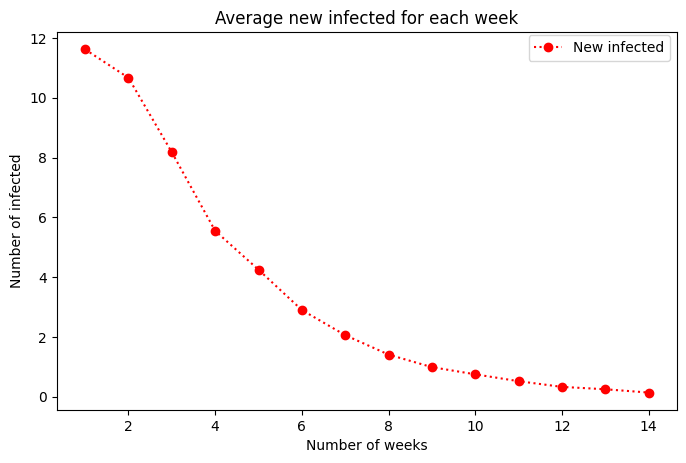

In [ ]:
# plot average new infected for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(1, n_weeks), avg_new_I[1:], 'ro:', label= "New infected")
ax.set_title("Average new infected for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of infected")
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

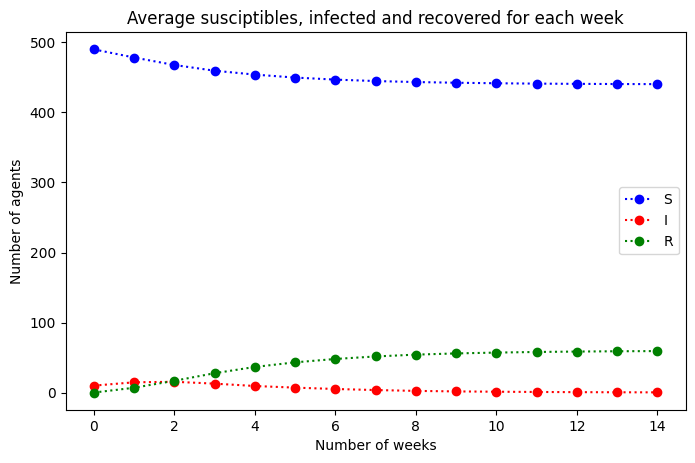

In [ ]:
# plot susciptible, infected and recovered for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(0, n_weeks), avg_S, "bo:", label="S")
ax.plot(range(0, n_weeks), avg_I, "ro:", label="I")
ax.plot(range(0, n_weeks), avg_R, "go:", label="R")
ax.set_title("Average susciptibles, infected and recovered for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of agents")
    
ax.legend()
plt.show()

##1.2 Generate a random graph

From now on we will use random graphs with preferential attachment to run our simulations. 

To generate the graph, we start from a complete graph with k+1 nodes. At every iteration we create a node with degree $w_t = c = k/2$. At the end we obtained a graph with n nodes and average degree $k$.

In [ ]:
# function to generate a random graph with preferential attachment

# Input
# n: the number of nodes
# k: average degree

# Output
# G: random graph with preferential attachment

def generate_GPA(n, k):
  G = nx.complete_graph(k+1)
  c = int(k/2)

  for node in range(2,n):
      deg_PA = [d for nod, d in G.degree()] 
      deg_PA = np.array(deg_PA)
      deg_PA = deg_PA/sum(deg_PA)
      neighbors = np.random.choice(G.nodes(), p=deg_PA, size=c, replace=False)
      G.add_node(node)
      for neigh in neighbors:
          G.add_edge(node,neigh) 

  return G

In [ ]:
G = generate_GPA(1000, 6)
W = nx.adjacency_matrix(G)
W = W.toarray()
w = np.sum(W, axis=1)
print("Average degree: ", np.mean(w))

Average degree:  6.001


# 2 Simulate a pandemic without vaccination

As done in point 1.1, we simulate the pandemic with a random graph with an average degree higher than before. An higher average degree means every node is connected with more nodes, so we expect an higher number of infected agents compared to previous simulation.

Lastly we plot the new average infected individual per week starting from week 1 and the average susceptibles, infected and recovered agents per week.

In [ ]:
#perform the simulations

N = 500
k = 6
GPA = generate_GPA(N, k)
beta = 0.3
rho = 0.7
n_weeks = 15
n_simulations = 100
I0 = 10
S = np.zeros((n_simulations, n_weeks))
I = np.zeros((n_simulations, n_weeks))
R = np.zeros((n_simulations, n_weeks))
new_I = np.zeros((n_simulations, n_weeks))
for i in range(n_simulations):
  susceptibles, infected, recovered, new_infected  = SIR_simulation(GPA, N, beta, rho, n_weeks, I0)
  S[i, :] = susceptibles
  I[i, :] = infected
  R[i, :] = recovered
  new_I[i,:] = new_infected

avg_S = np.average(S, axis=0)
avg_I = np.average(I, axis=0)
avg_R = np.average(R, axis=0)
avg_new_I = np.average(new_I, axis=0)

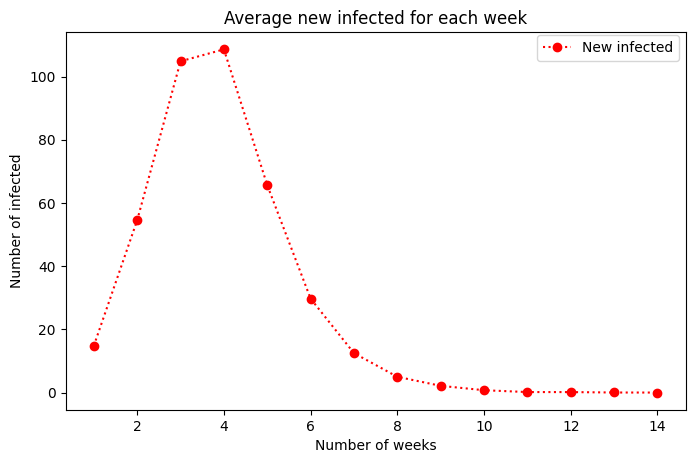

In [ ]:
# plot average new infected for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(1, n_weeks), avg_new_I[1:], 'ro:', label= "New infected")
ax.set_title("Average new infected for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of infected")
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

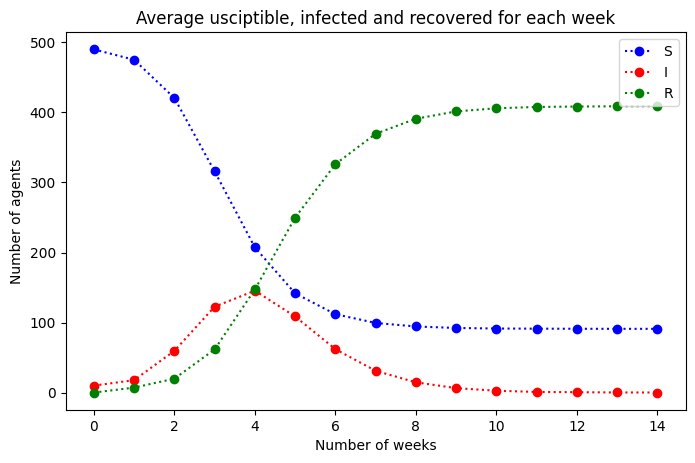

In [ ]:
# plot susciptible, infected and recovered for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(0, n_weeks), avg_S, "bo:", label="S")
ax.plot(range(0, n_weeks), avg_I, "ro:", label="I")
ax.plot(range(0, n_weeks), avg_R, "go:", label="R")
ax.set_title("Average usciptible, infected and recovered for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of agents")
    
ax.legend()
plt.show()

# 3 Simulate a pandemic with vaccination

Now we introduce in the SIR model a new variable V, the vaccinated agents. For this task a vector $V(t)$ is given. Every element in the vector is the percentage of vaccinated nodes at week t. To simulate the pandemic with vaccination we add a vaccination step to the previous algorithm.
At the beginnign of the week we vaccinate new agents according to the given vector as the difference between the percentage stated in the vector and the percentage of vaccinated agents in the past weeks. In reality we are not able to tell which agents have been infected by the H1N1-virus, so we pick the agents to be vaccinated independently from their state. The individuals are selected uniformly. After the vaccination step is finished, we go on with the simulations as before.

At the end of the simulations, we show with some plots the number of average new infected and vaccinated individual at each week and the average number of susceptibles, infected, recovered and vaccinated agents.
As we can see, with vaccination the virus is not spreading as before as some agents are immune. We can clearly see this in week 3, where there is the maximum value of new infected agents. With vaccination we have 50 new infected agents, without vaccination (previous section) we have more than 100. The difference is relevant, so this vaccination strategy was a good choice to contrast the spread of the virus.

In [ ]:
#perform the simulations
Vt = np.array([0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60])
N = 500
GPA = generate_GPA(N, 6)
beta = 0.3
rho = 0.7
n_weeks = 15
n_simulations = 100
I0 = 10
S = np.zeros((n_simulations, n_weeks))
I = np.zeros((n_simulations, n_weeks))
R = np.zeros((n_simulations, n_weeks))
V = np.zeros((n_simulations, n_weeks))
new_I = np.zeros((n_simulations, n_weeks))
new_V = np.zeros((n_simulations, n_weeks))
for i in range(n_simulations):
  susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated = SIR_simulation(GPA, N, beta, rho, n_weeks, I0, Vt)
  S[i, :] = susceptibles
  I[i, :] = infected
  R[i, :] = recovered
  V[i, :] = vaccinated
  new_I[i,:] = new_infected
  new_V[i, :] = new_vaccinated

avg_S = np.average(S, axis=0)
avg_I = np.average(I, axis=0)
avg_R = np.average(R, axis=0)
avg_V = np.average(V, axis=0)
avg_new_I = np.average(new_I, axis=0)
avg_new_V = np.average(new_V, axis=0)

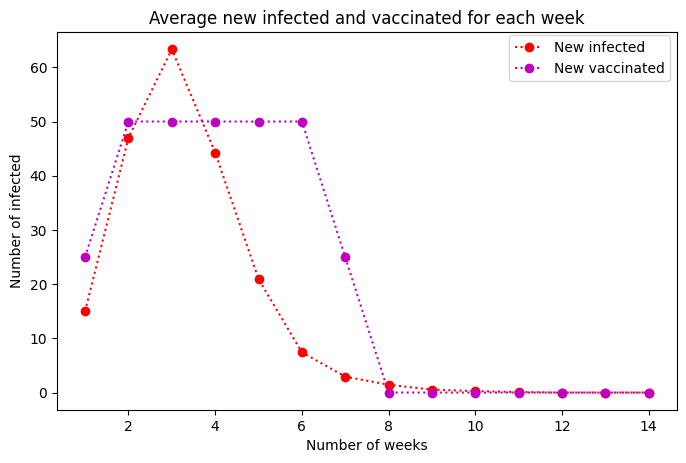

In [ ]:
# plot average new infected and vaccinated for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(1, n_weeks), avg_new_I[1:], 'ro:', label= "New infected")
plt.plot(range(1, n_weeks), avg_new_V[1:], "mo:", label="New vaccinated")
ax.set_title("Average new infected and vaccinated for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of infected")
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

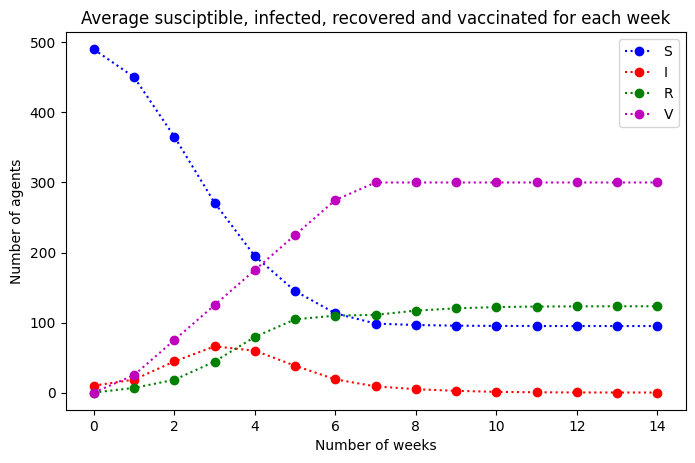

In [ ]:
# plot susciptible, infected, recovered and vaccinated for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(0, n_weeks), avg_S, "bo:",label="S")
ax.plot(range(0, n_weeks), avg_I, "ro:", label="I")
ax.plot(range(0, n_weeks), avg_R, "go:", label="R")
ax.plot(range(0, n_weeks), avg_V, "mo:", label="V")
ax.set_title("Average susciptible, infected, recovered and vaccinated for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of agents")
    
ax.legend()
plt.show()

# 4 The H1N1 pandemic in Sweden 2009

Given the vector $I(t)$ containg the real data about the H1N1-virus spread is Sweden, we want to be able to predict such vector.

To do so, we develop an optimization algorithm to minimize the root meas square error,
$RMSE = \sqrt{\frac{1}{15}\sum_{i=1}^{15}(I(t)-I_o(t))^2}$

where $I_o(t)$ is the predicted vector.

We set the initial number of infected agents $I_o(0)$ equals to 1.

At each step we generate a parameters set with all the triplets obtained by the combination of the following three vectors: $\{k_o-\Delta k, k_o, k_o+\Delta k\}, \{\beta_o-\Delta \beta, \beta_o, \beta_o+\Delta \beta\}, \{\rho_o-\Delta \rho, \rho_o, \rho_o+\Delta \rho\} $. For each triplet we generate the graph $G$ with preferential attachment and we simulate the pandemic 10 times. At the end we compute the average of the new infected agents and the RMSE. Once we have done with all configurations we pick the lowest RMSE and the parameters associated with it to go on with the next iteration. If the new parameters found are the same as the previous iteration and if the new RMSE is higher than before, we stop the algorithm.

We start with the following parameters:

* $k_o = 8$, $\Delta k = 1$,
* $\beta_o = 0.3$, $\Delta \beta = 0.025$,
* $\rho_o = 0.6$, $\Delta \rho = 0.025$,

In [ ]:
N = 934
k0 = 8 
dk = 1
beta0 = 0.3
dbeta = 0.025
rho0 = 0.6
drho = 0.025
n_weeks = 15
n_simulations = 10
I0 = 1
Vt = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60])
It = np.array([1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0])
searching = True
step = 0
old_RMSE = 20

while searching:
  print("Starting step {} ...".format(step))
  k = np.array([k0-dk, k0, k0+dk])

  beta_minus = beta0-dbeta
  if beta_minus < 0:
    beta_minus = 0
  beta_plus = beta0+dbeta
  if beta_plus > 1:
    beta_plus = 1
  beta = np.array([beta_minus, beta0, beta_plus])

  rho_minus = rho0-drho
  if rho_minus < 0:
    rho_minus = 0
  rho_plus = rho0+drho
  if rho_plus > 1:
    rho_plus = 1
  rho = np.array([rho_minus, rho0, rho_plus])

  parameters_set = np.array(np.meshgrid(k, beta, rho)).T.reshape(-1,3)
  RMSE = np.zeros(len(parameters_set))
  array_avg_new_I = np.zeros((len(parameters_set), n_weeks))

  for i, p in enumerate(parameters_set):
    k = int(p[0])
    beta = p[1]
    rho = p[2]
    GPA = generate_GPA(N, k)
    new_I = np.zeros((n_simulations, n_weeks))
    for j in range(n_simulations):
      _, _, _, new_infected, _, _  = SIR_simulation(GPA, N, beta, rho, n_weeks, I0, Vt)
      new_I[j,:] = new_infected

    avg_new_I = np.average(new_I, axis=0)
    array_avg_new_I[i] = avg_new_I
    RMSE[i] = np.sqrt(1/15* np.sum((avg_new_I - It)**2))

  index_best_RMSE = np.random.choice(np.where(RMSE == np.amin(RMSE))[0], size=1)[0]
  new_k = parameters_set[index_best_RMSE][0]
  new_beta = parameters_set[index_best_RMSE][1]
  new_rho = parameters_set[index_best_RMSE][2]

  print("RMSE vector ", RMSE)
  print("Best RMSE", RMSE[index_best_RMSE])
  print("Best new I", array_avg_new_I[index_best_RMSE])
  print("Parameters found: k={} beta={} rho={}".format(new_k, new_beta, new_rho))
  if new_k != k0 and new_beta != beta0 and new_rho != rho0 and RMSE[index_best_RMSE] <= old_RMSE :
    k0 = new_k
    beta0 = new_beta
    rho0 = new_rho
    old_RMSE = RMSE[index_best_RMSE]
    step +=1
  else:
    print("Algorithm finished with {} steps".format(step))
    searching=False

Starting step 0 ...
RMSE vector  [ 5.80195369  9.48180714 17.49969524  9.32394766 14.33552696 21.4110719
  9.62029106 18.31573094  8.60616058  6.47883734  7.20143504  8.52979093
 19.12166311 11.3226322  29.32484726 19.78078192 13.10763136 18.57365518
  7.31459728  7.43236167  4.3504789  23.74872628 17.92965886  9.11595671
 17.70945134 17.43534724 19.6872209 ]
Best RMSE 4.350478900841455
Best new I [ 0.   0.8  1.7  4.2 12.8 24.1 27.  19.5 12.6  7.   4.   2.9  1.6  0.9
  0.3]
Parameters found: k=7.0 beta=0.325 rho=0.625
Starting step 1 ...
RMSE vector  [ 8.44140589  6.96649123 18.02670242 11.69099368  7.74093018 15.90846735
 12.91301669 22.62724022 23.29879825  5.08284697  4.21908363  7.50279948
  6.96567776  9.88116053  7.10220623  5.28576705 15.09372938 24.78531823
  7.60973061 10.84155585 12.61654998  8.37567908 15.22296511 17.69969868
  4.98925512 21.38053632 37.33069336]
Best RMSE 4.219083628783229
Best new I [ 0.   1.4  2.7  7.2 13.3 23.3 26.9 22.9 13.8 10.2  7.5  4.3  3.5  1.5
  1

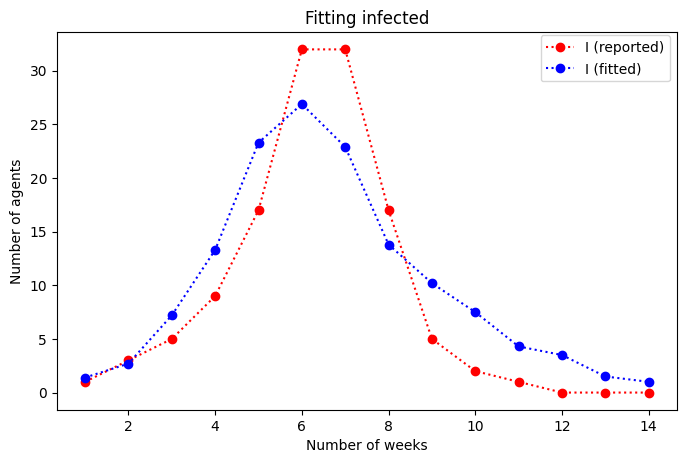

In [ ]:
avg_new_I = array_avg_new_I[index_best_RMSE]
plt.figure(figsize=(8,5), dpi=100)
plt.plot(range(1, n_weeks), It[1:], "ro:", label="I (reported)")
plt.plot(range(1, n_weeks), avg_new_I[1:], "bo:", label="I (fitted)")
plt.title("Fitting infected")
plt.xlabel("Number of weeks")
plt.ylabel("Number of agents")
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

Now we perform 100 simulations with the best parameters obtained above.

In [ ]:
N=934
k0 = int(k0)
GPA = generate_GPA(N, k0)
beta = beta0
rho = rho0
n_weeks = 15
n_simulations = 100
I0 = 1
S = np.zeros((n_simulations, n_weeks))
I = np.zeros((n_simulations, n_weeks))
R = np.zeros((n_simulations, n_weeks))
V = np.zeros((n_simulations, n_weeks))
new_I = np.zeros((n_simulations, n_weeks))
new_V = np.zeros((n_simulations, n_weeks))
for i in range(n_simulations):
  susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated = SIR_simulation(GPA, N, beta, rho, n_weeks, I0, Vt)
  S[i, :] = susceptibles
  I[i, :] = infected
  R[i, :] = recovered
  V[i, :] = vaccinated
  new_I[i,:] = new_infected
  new_V[i, :] = new_vaccinated

avg_S = np.average(S, axis=0)
avg_I = np.average(I, axis=0)
avg_R = np.average(R, axis=0)
avg_V = np.average(V, axis=0)
avg_new_I = np.average(new_I, axis=0)
avg_new_V = np.average(new_V, axis=0)

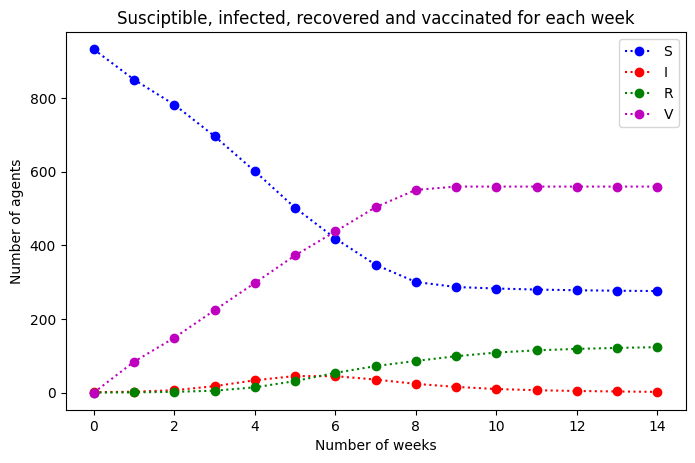

In [ ]:
# susciptible, infected, recovered and vaccinated for each week
fig = plt.figure(figsize=(8,5), dpi=100)
ax = plt.subplot(111)
ax.plot(range(0, n_weeks), avg_S, "bo:",label="S")
ax.plot(range(0, n_weeks), avg_I, "ro:", label="I")
ax.plot(range(0, n_weeks), avg_R, "go:", label="R")
ax.plot(range(0, n_weeks), avg_V, "mo:", label="V")
ax.set_title("Susciptible, infected, recovered and vaccinated for each week")
ax.set_xlabel("Number of weeks")
ax.set_ylabel("Number of agents")
    
ax.legend()
plt.show()

# 5 Challenge

We performs additional simulation with other random graphs:
* the Erdos-Renyi model: the RMSE remains very high, around 13.

In [3]:
def generate_ER(N, k):
  p = (N*k)/(sp.special.binom(N,2)) 
  # add links between couple of different nodes with probability p
  GER = nx.erdos_renyi_graph(N, p, directed=False)
  return GER

In [4]:
N = 934
k = 7
GER = generate_ER(934, 7)

In [11]:
N = 934
k0 = 8
dk = 1
beta0 = 0.5
dbeta = 0.1
rho0 = 0.6
drho = 0.1
n_weeks = 15
n_simulations = 10
I0 = 1
Vt = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60])
It = np.array([1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0])
searching = True
step = 0
old_RMSE = 100

while searching:
  print("Starting step {} ...".format(step))
  k = np.array([k0-dk, k0, k0+dk])

  beta_minus = beta0-dbeta
  if beta_minus < 0:
    beta_minus = 0
  beta_plus = beta0+dbeta
  if beta_plus > 1:
    beta_plus = 1
  beta = np.array([beta_minus, beta0, beta_plus])

  rho_minus = rho0-drho
  if rho_minus < 0:
    rho_minus = 0
  rho_plus = rho0+drho
  if rho_plus > 1:
    rho_plus = 1
  rho = np.array([rho_minus, rho0, rho_plus])

  parameters_set = np.array(np.meshgrid(k, beta, rho)).T.reshape(-1,3)
  RMSE = np.zeros(len(parameters_set))
  array_avg_new_I = np.zeros((len(parameters_set), n_weeks))

  for i, p in enumerate(parameters_set):
    k = int(p[0])
    beta = p[1]
    rho = p[2]
    GER = generate_ER(N, k)
    new_I = np.zeros((n_simulations, n_weeks))
    for j in range(n_simulations):
      _, _, _, new_infected, _, _  = SIR_simulation(GER, N, beta, rho, n_weeks, I0, Vt)
      new_I[j,:] = new_infected

    avg_new_I = np.average(new_I, axis=0)
    array_avg_new_I[i] = avg_new_I
    RMSE[i] = np.sqrt(1/15* np.sum((avg_new_I - It)**2))

  index_best_RMSE = np.random.choice(np.where(RMSE == np.amin(RMSE))[0], size=1)[0]
  new_k = parameters_set[index_best_RMSE][0]
  new_beta = parameters_set[index_best_RMSE][1]
  new_rho = parameters_set[index_best_RMSE][2]

  print("Best RMSE", RMSE[index_best_RMSE])
  print("Best new I", array_avg_new_I[index_best_RMSE])
  print("Parameters found: k={} beta={} rho={}".format(new_k, new_beta, new_rho))
  print(RMSE)
  if new_k != k0 and new_beta != beta0 and new_rho != rho0 and RMSE[index_best_RMSE] <= old_RMSE :
    k0 = new_k
    beta0 = new_beta
    rho0 = new_rho
    old_RMSE = RMSE[index_best_RMSE]
    step +=1
  else:
    print("Algorithm finished with {} steps".format(step))
    searching=False

Starting step 0 ...
Best RMSE 48.033384223891616
Best new I [0.000e+00 3.400e+00 1.260e+01 4.930e+01 1.262e+02 1.495e+02 5.750e+01
 1.330e+01 1.800e+00 6.000e-01 1.000e-01 2.000e-01 0.000e+00 0.000e+00
 0.000e+00]
Parameters found: k=7.0 beta=0.4 rho=0.5
[ 48.03338422  80.36810313  90.44965082  80.51761712  84.67225441
 106.73559544  87.23939859  95.72111575 102.28236407  54.42655602
  82.97764358  92.25198462  77.46049316  98.32934794  95.71655378
  93.10032939 104.46953623 100.76499061  75.73088318  68.99734294
  88.00316282  85.46996353  79.38457449 105.20419827  93.07842213
 105.97594381 110.26661326]
Starting step 1 ...
Best RMSE 24.94671655081419
Best new I [ 0.   2.5  6.6 16.8 43.2 74.8 87.1 65.6 35.4 16.5  7.3  3.2  0.6  0.2
  0.2]
Parameters found: k=6.0 beta=0.30000000000000004 rho=0.6
[ 41.34034349  47.43164907  74.92591897  52.5605936   75.22952435
  90.55841577  48.94918454  73.01377039 100.82421336  34.30718098
  54.05775923  67.52221363  40.67654525  63.34626008  78.5518